In [ ]:
#import packages for plotting

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import rfftfreq
from scipy.signal import butter,filtfilt

In [ ]:
#import packages for plotting

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import rfftfreq
from scipy.signal import butter,filtfilt

In [33]:
#import packages for plotting

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import rfftfreq
from scipy.signal import butter,filtfilt

In [51]:
#%cd /Users/frederikkeuldahl/Desktop/Fagprojekt/GitHub/AALdata
%cd /Users/frederikkeuldahl/Desktop/Fagprojekt/GitHub

/Users/frederikkeuldahl/Desktop/Fagprojekt/GitHub


In [53]:
#read all datafiles

n = 215 #highest ID of face filename

notfound = {}
X = np.array()

for i in range(n):
    try:
            df = pd.read_csv(f"AALdata/sub-{(i+1):04d}_faces.csv",sep=",",header=None)
    
    except FileNotFoundError:
        
            notfound[i] = f"{(i+1):04d}"
            continue
    X.append(df.values)

print(f"files not found {[*notfound.values()]}")
print(f"Number of files not found: {len(notfound)}")
print(f"Number of subjects {len(X)}")
print(f"Dimentions of data {(len(X),X[0].shape[0],X[0].shape[1])}")

files not found ['0022', '0023', '0032', '0068', '0072', '0073', '0086', '0089', '0106', '0107', '0144', '0152']
Number of files not found: 12
Number of subjects 203
Dimentions of data (203, 90, 330)


<function matplotlib.pyplot.show(*args, **kw)>

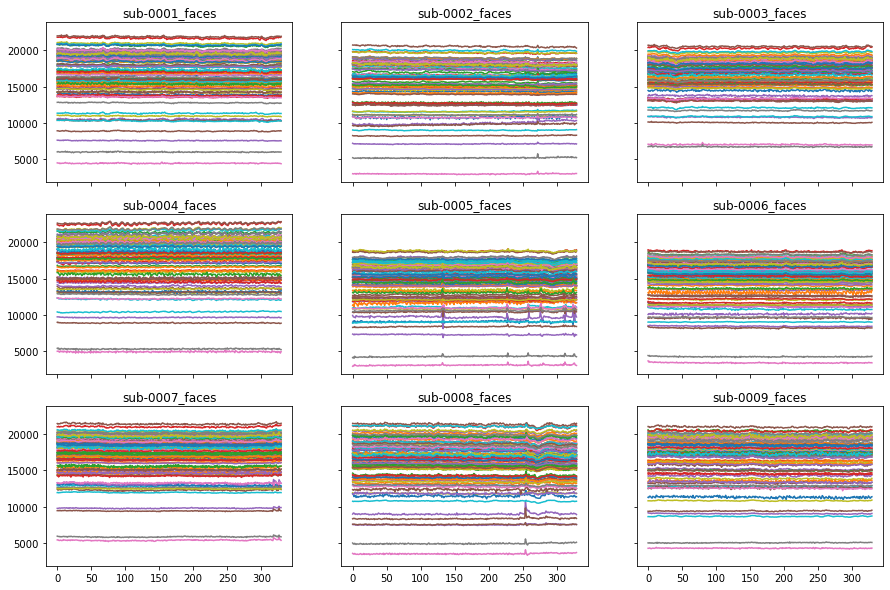

In [37]:
#plot some of the raw data

fig, axs = plt.subplots(3, 3,sharex=True,sharey=True, figsize=(15,10))

for i in range(3):
    for j in range(3):
        ID = 3*i+j+1
        axs[i, j].set_title(f"sub-000{ID}_faces")
        for k in range(90):
            axs[i,j].plot(X[ID][k,])

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

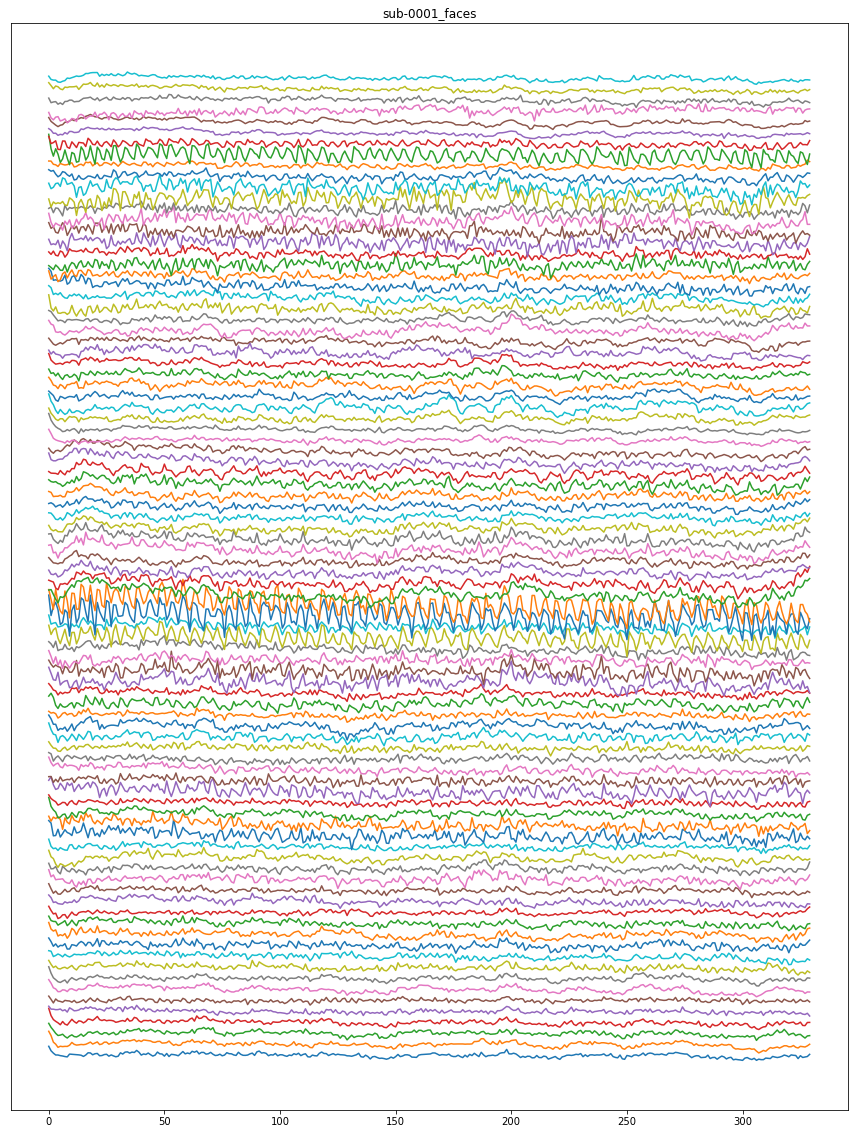

In [38]:
#plot one of full dataset (no y axis)

plt.figure(figsize=(15,20))
plt.title("sub-0001_faces")
for i in range(90):
    plt.plot(X[0][i,:]-np.mean(X[0][i,:])+200*i)

plt.yticks([])
plt.show

In [39]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut=0.01, highcut=0.1, fs=4/3, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [40]:
time = np.arange(0,330*3/4,3/4)

data_raw = X[0][0:5,:]
print(data_raw.shape)

(5, 330)


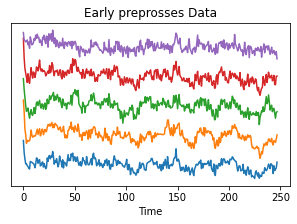

In [41]:
plt.figure(figsize=(5,3))
#plt.ylabel("Brain region")
#plt.yticks([0,200,400,600,800],["1","2","3","4","5"])

plt.title("Early preprosses Data")
plt.xlabel("Time")
plt.yticks([])


for i in range(5):
    plt.plot(time,(data_raw[i,:] - np.mean(data_raw[i,:]) + 200 * i))
             
plt.show()

(5, 330)


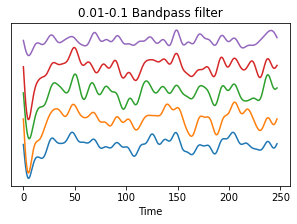

In [42]:
data_bandpass = butter_bandpass_filter(data_raw)
print(data_bandpass.shape)

plt.figure(figsize=(5,3))
#plt.ylabel("Brain region")
#plt.yticks([0,120,240,360,480],["1","2","3","4","5"])
plt.title("0.01-0.1 Bandpass filter")
plt.xlabel("Time")
plt.yticks([])


for i in range(5):
    plt.plot(time,butter_bandpass_filter(data_bandpass[i,:]) + 120 * i)

plt.show()

In [43]:
from scipy.signal import hilbert

def Hilbert_transform(signal):
    A_t = hilbert(signal)
    s_t , sh_t = np.real(A_t),np.imag(A_t)
    return s_t, sh_t

def phase(s_t, sh_t):
    theta_t = np.arctan(sh_t/s_t)
    return theta_t

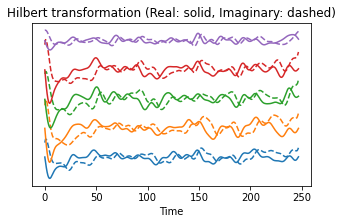

In [44]:
 c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(5,3))
#plt.ylabel("Brain region")
#plt.yticks([0,200,400,600,800],["1","2","3","4","5"])
plt.yticks([])
plt.title("Hilbert transformation (Real: solid, Imaginary: dashed)")
plt.xlabel("Time")



S_t = []
SH_t = []

for i in range(5):
    s_t, sh_t = Hilbert_transform(data_bandpass[i,:])
    S_t.append(s_t)
    SH_t.append(sh_t)
    plt.plot(time,s_t + 220 * i, c[i] )
    plt.plot(time,sh_t + 220 * i, "--")

plt.show()

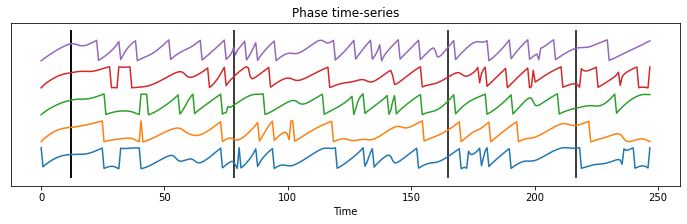

In [45]:
plt.figure(figsize=(12,3))
#plt.ylabel("Brain region")
#plt.yticks([0,4,8,12,16],["1","2","3","4","5"])
plt.yticks([])
plt.title("Phase time-series")
plt.xlabel("Time")

timemarks = [12,12,78,165,217]

for i in range(5):
    theta_t = phase(S_t[i], SH_t[i])
    plt.plot(time,theta_t + 4 * i)
    plt.vlines(timemarks[i], -3, 19, linestyles ="solid", colors ="k")


plt.show()

In [46]:
from numpy.linalg import eigh


def LeadingEigenVector(At):

    EigenValues , EigenVectors = eigh(At)
    LeV = EigenVectors[:,-1]

    return LeV

def CoherenceMap(Theta):
    N,T = Theta.shape
    
    LEiDA_Signal = np.zeros((N,T))

    At = np.zeros((N,N))

    for t in range(T):
        CurrentSample = Theta[:,t]
        for j in range(N):
            for k in range(N):
                At[j,k]=np.cos(CurrentSample[j]-CurrentSample[k])
                
        LEiDA_Signal[:,t] = LeadingEigenVector(At)
    
        if t in timemarks:
            plt.title(f"CoherenceMap for timestep {t} ")
            plt.imshow(At, interpolation='nearest')
            plt.colorbar()
            plt.show()
    
    return LEiDA_Signal

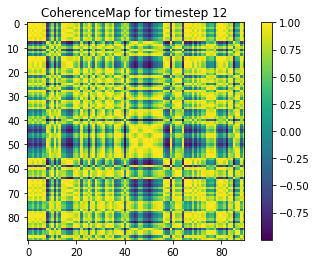

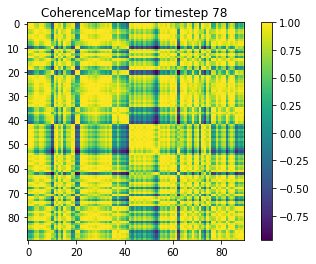

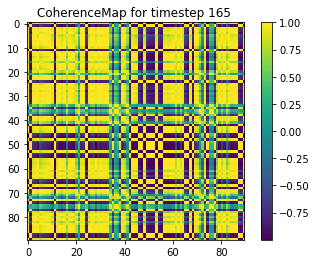

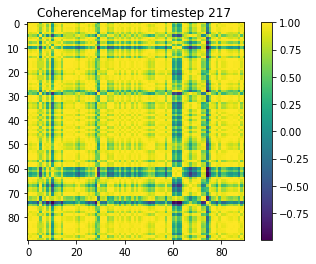

In [47]:
N,T = X[3].shape
X_filtered = np.zeros((N,T))

for idx, x in enumerate(X[3]):
    X_filtered[idx,:] = butter_bandpass_filter(x)


#%%

Theta = np.zeros((N,T))


for idx, x in enumerate(X_filtered):
    s_t,sh_t=Hilbert_transform(x)
    Theta_t = phase(s_t, sh_t)
    Theta[idx,:] = Theta_t

LEiDA_Signal = CoherenceMap(Theta)

Text(0.5, 0, 'Brain region')

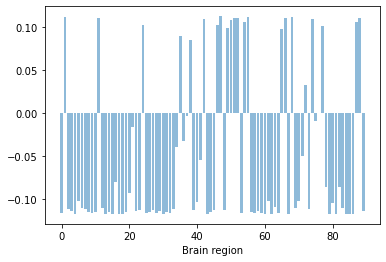

In [48]:
y_pos = np.arange(len(LEiDA_Signal[:,12]))


plt.bar(y_pos, LEiDA_Signal[:,165], align='center', alpha=0.5)
plt.xlabel("Brain region")